## Perform standard imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load the dataset

In [2]:

df = pd.read_csv('Datasets/stack_dataset_long.csv',index_col=0,parse_dates=True)
len(df)

1032

## Plotting time series data

In [3]:
from datetime import datetime, timedelta
t = np.arange(np.datetime64('2022-06-01'), np.datetime64('2022-07-14'),step=7)
t

array(['2022-06-01', '2022-06-08', '2022-06-15', '2022-06-22',
       '2022-06-29', '2022-07-06', '2022-07-13'], dtype='datetime64[D]')

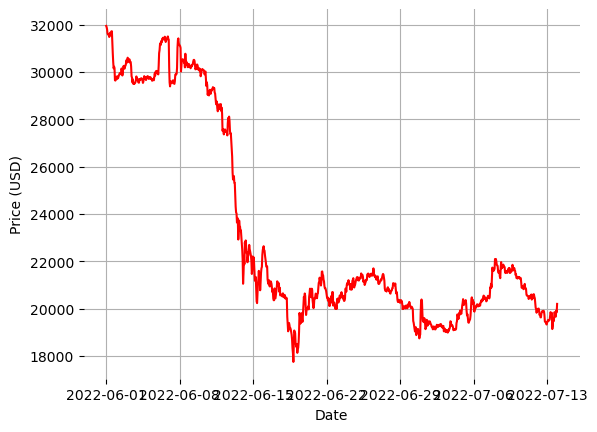

In [4]:
fig, ax = plt.subplots()
ax.plot(df['price'],c='red')
ax.grid()
ax.set_xticks(t)

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')

plt.xticks(rotation = 0)
plt.rcParams['figure.figsize'] = [8, 4]
#plt.show()
#plt.savefig('../Write-Up/CHAPTER_5/bitcoin_price_python_inf.png', format='png',dpi=600)

plt.show()

## Prepare the data


In [6]:
# Extract values from the source .csv file
y = df['price'].values.astype(float)
X = df[['tweet_count','tweet_gt','POS_I','NEG_I','NEU_I','price']].values.astype(float)

# Define a test size
test_size = 24

# Create train and test sets
train_set = X[:-test_size]
test_set = X[-test_size:]

### Normalize the data


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [8]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 6))

## Prepare data for LSTM Model

In [9]:
# Convert train_norm from an array to a tensor
#train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm = torch.FloatTensor(train_norm)

# Define a window size
window_size = 24

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1][0]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data) 

984

### Define the model

In [10]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=6,hidden_size=50,output_size=6):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

### Instantiate the model, define loss and optimization functions

In [11]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

model

LSTMnetwork(
  (lstm): LSTM(6, 50)
  (linear): Linear(in_features=50, out_features=6, bias=True)
)

In [12]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

  1200
 10000
   200
   200
   300
     6
______
 11906


### Train the model

In [13]:
epochs = 250

loss_array = []
track_array = []
total_track_array = []

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        track = model(seq).detach().numpy()
        track_array.append(track)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    loss_array = np.append(loss_array,loss.item())
    total_track_array.append(track_array)
    track_array = []
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

loss_array.tofile('/Model Loss Data/loss_{}.csv'.format(datetime.now()),sep=',')

Epoch:  1 Loss: 0.25200969
Epoch:  2 Loss: 0.20956743
Epoch:  3 Loss: 0.15221108
Epoch:  4 Loss: 0.07547013
Epoch:  5 Loss: 0.05178675
Epoch:  6 Loss: 0.04624715
Epoch:  7 Loss: 0.04338069
Epoch:  8 Loss: 0.04191838
Epoch:  9 Loss: 0.04162938
Epoch: 10 Loss: 0.04202826
Epoch: 11 Loss: 0.04251586
Epoch: 12 Loss: 0.04278905
Epoch: 13 Loss: 0.04284601
Epoch: 14 Loss: 0.04276753
Epoch: 15 Loss: 0.04256748
Epoch: 16 Loss: 0.04223921
Epoch: 17 Loss: 0.04180405
Epoch: 18 Loss: 0.04129417
Epoch: 19 Loss: 0.04073472
Epoch: 20 Loss: 0.04014328
Epoch: 21 Loss: 0.03953359
Epoch: 22 Loss: 0.03891875
Epoch: 23 Loss: 0.03831222
Epoch: 24 Loss: 0.03772722
Epoch: 25 Loss: 0.03717531
Epoch: 26 Loss: 0.03666513
Epoch: 27 Loss: 0.03620157
Epoch: 28 Loss: 0.03578611
Epoch: 29 Loss: 0.03541747
Epoch: 30 Loss: 0.03509246
Epoch: 31 Loss: 0.03480692
Epoch: 32 Loss: 0.03455639
Epoch: 33 Loss: 0.03433646
Epoch: 34 Loss: 0.03414322
Epoch: 35 Loss: 0.03397318
Epoch: 36 Loss: 0.03382343
Epoch: 37 Loss: 0.03369140
E

### Plotting the loss over the epoch

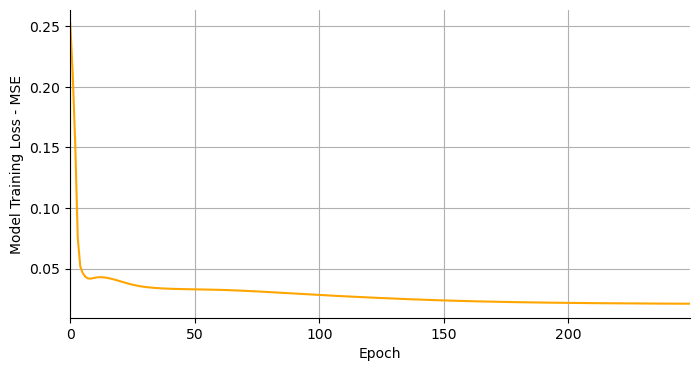

In [14]:
#Plotting the loss over the epoch
fig, ax = plt.subplots()
ax.plot(loss_array,c='orange')
ax.grid()

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xlabel('Epoch')
ax.set_ylabel('Model Training Loss - MSE')
plt.autoscale(axis='x',tight=True)
plt.xticks(rotation = 0)
plt.rcParams['figure.figsize'] = [8, 4]
#plt.show()
plt.savefig('../Write-Up/CHAPTER_5/LOSS_MODEL_MSE_inf.png', format='png',dpi=600)

plt.show()


In [15]:
total_track_array = np.array(total_track_array)

In [16]:
def actual_pred_loss(element):
    element = scaler.inverse_transform(element)
    transform_array = []
    for i in range(len(element)):
        transform_array = np.append(transform_array,element[i][5])
    
    transform_array = np.array(transform_array)
    error = mean_squared_error(df['price']['2022-06-02':'2022-07-12'],transform_array)
    
    return error,transform_array


In [3]:
act_loss = []
act_pred = []
for epoch in range(len(total_track_array)):
   a,b = actual_pred_loss(total_track_array[epoch])
   act_loss = np.append(act_loss,a**0.5)
   act_pred.append(b)

act_loss = np.array(act_loss)
act_pred = np.array(act_pred)

NameError: name 'total_track_array' is not defined

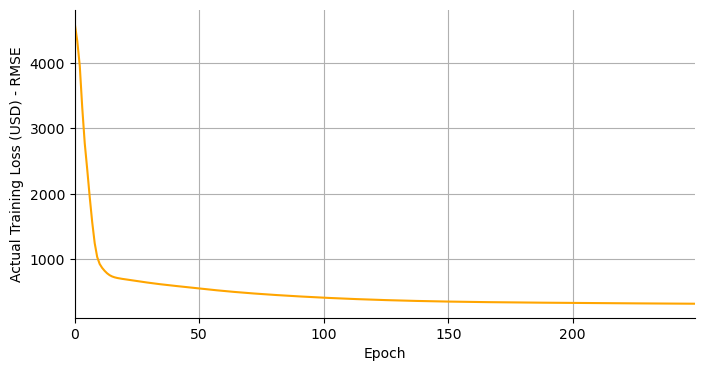

In [18]:
fig, ax = plt.subplots()
ax.plot(act_loss,c='orange')
ax.grid()

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xlabel('Epoch')
ax.set_ylabel('Actual Training Loss (USD) - RMSE')
plt.autoscale(axis='x',tight=True)
plt.xticks(rotation = 0)
plt.rcParams['figure.figsize'] = [8, 4]
#plt.show()
#plt.savefig('../Write-Up/CHAPTER_5/bitcoin_price_python_inf.png', format='png',dpi=600)

plt.show()

## Run predictions and compare to known test set

In [19]:
future = 24
preds = train_norm[-window_size:].tolist()
len(preds)

24

In [20]:
future = 24

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).numpy())

/var/folders/zm/bf3yd8d526x62v9mglx0hpqw0000gn/T/ipykernel_89494/2553314220.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646981653/work/torch/csrc/utils/tensor_new.cpp:233.)
  seq = torch.FloatTensor(preds[-window_size:])


### Invert the normalization

In [21]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 6))

## Plot the results


In [22]:
import datetime
from datetime import timedelta
# Remember that the stop date has to be later than the last predicted value.
#x = np.arange('2018-02-01', '2019-02-01',dtype='datetime64[M]').astype('datetime64[D]')
x = pd.date_range(start='2022-07-13', end='2022-07-14',freq='H')[:-1]
x2 = pd.date_range(start='2022-06-02', end='2022-07-13',freq='H')[:-1]

In [23]:
predicitons_array = []
for i in range(len(true_predictions)):
    predicitons_array = np.append(predicitons_array,true_predictions[i][5])

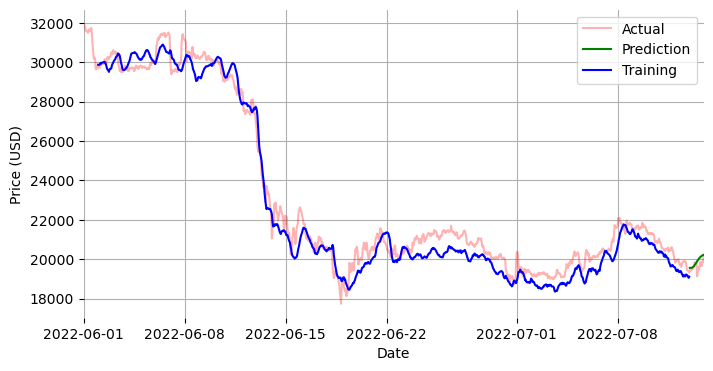

In [24]:
# plt.figure(figsize=(12,4))
# plt.ylabel('Sales (millions of dollars)')
# plt.grid(True)
# plt.autoscale(axis='x',tight=True)
# plt.plot(df['price'])
# plt.plot(x,predicitons_array)
# plt.show()




#Plotting the loss over the epoch
fig, ax = plt.subplots()
ax.plot(df['price'],c='red',alpha=0.3,label='Actual')
ax.plot(x,predicitons_array,c='green',label = 'Prediction')
ax.plot(x2,act_pred[25],c='blue',label = 'Training')
ax.grid()

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
plt.autoscale(axis='x',tight=True)
plt.xticks(rotation = 0)
plt.rcParams['figure.figsize'] = [8, 4]
#plt.show()
#plt.savefig('../Write-Up/CHAPTER_5/bitcoin_price_python_inf.png', format='png',dpi=600)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.autoscale(axis='x',tight=True)
plt.legend()
plt.show()

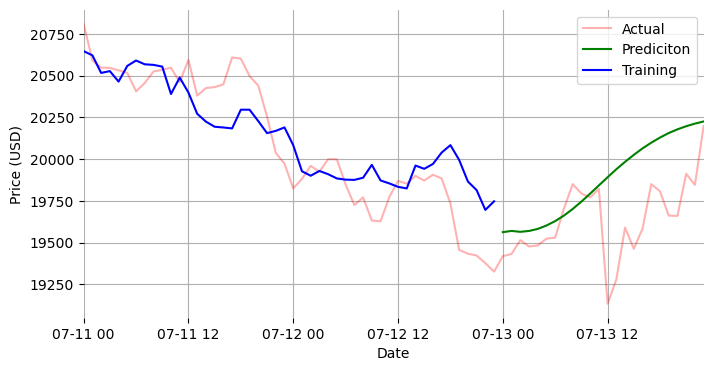

In [25]:
# # Plot the end of the graph
# fig = plt.figure(figsize=(12,4))
# plt.title('Beer, Wine, and Alcohol Sales')
# plt.ylabel('Sales (millions of dollars)')
# plt.grid(True)
# plt.autoscale(axis='x',tight=True)
# fig.autofmt_xdate()

# # Select the end of the graph with slice notation:
# plt.plot(df['price']['2022-07-11':])
# plt.plot(x,predicitons_array)
# plt.show()

#Plotting the loss over the epoch
fig, ax = plt.subplots()
ax.plot(df['price']['2022-07-11':],c='red',alpha=0.3,label='Actual')
ax.plot(x,predicitons_array,c='green',label='Prediciton')
ax.plot(x2[-48:],act_pred[-1][-48:],c='blue',label = 'Training')
ax.grid()

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
plt.autoscale(axis='x',tight=True)
plt.xticks(rotation = 0)
plt.rcParams['figure.figsize'] = [8, 4]
#plt.show()
#plt.savefig('../Write-Up/CHAPTER_5/bitcoin_price_python_inf.png', format='png',dpi=600)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.autoscale(axis='x',tight=True)
plt.legend()
plt.show()

In [32]:
loss_array[-1]

0.020955180749297142

## Results

In [26]:
msq_train = mean_squared_error(df['price']['2022-06-02':'2022-07-12'],act_pred[-1])**0.5
msq_train

317.4548496728463

In [27]:
msq_test = mean_squared_error(df['price']['2022-07-13':],predicitons_array)**0.5
msq_test

335.99933024701096

#### Training RMSE
$303.96
#### Testing RMSE
$324.69

In [2]:
## Save Number of Epochs as well, due to underfitting or overfitting 
## Save Computation time for different models in the sheet
## Save accuracies at the same time
## Add script to save results
## Actual, Testing and Prediction for Statistical Comparisons
## Save variables to different worksheets

### Plotting Graphs

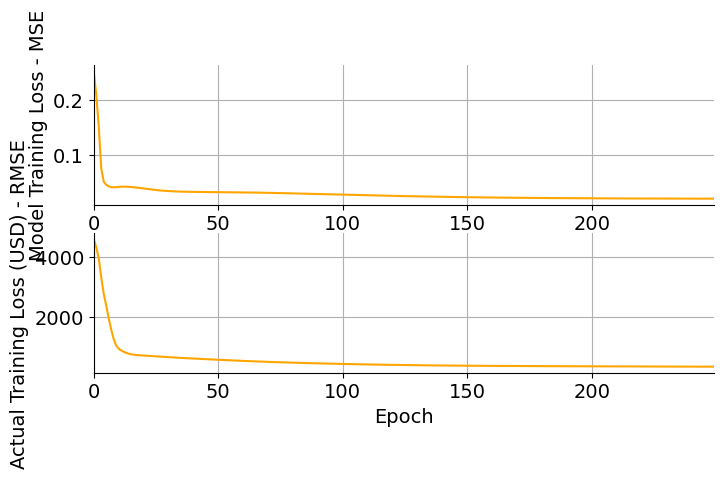

In [28]:
#Plotting the Model TRAINING loss over the epoch
fig, ax = plt.subplots(2,1)

ax[0].plot(loss_array,c='orange')
ax[0].grid()

ax[0].set_xlim([0,249])
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(True)
ax[0].spines['left'].set_visible(True)
#ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Model Training Loss - MSE',fontsize=14)


ax[1].plot(act_loss,c='orange')
ax[1].grid()

ax[1].set_xlim([0,249])
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(True)
ax[1].spines['left'].set_visible(True)
ax[1].set_xlabel('Epoch',fontsize=14)
ax[1].set_ylabel('Actual Training Loss (USD) - RMSE',fontsize=14)


plt.autoscale(axis='x',tight=True)
plt.xticks(rotation = 0)
plt.rcParams['figure.figsize'] = [10, 10]
#plt.savefig('../Write-Up/CHAPTER_5/LOSS_MODEL_MSE_inf.png', format='png',dpi=1000)

plt.show()


In [29]:
for i,item in enumerate(x2):
    if (i%327==0):
        print(i,item)

0 2022-06-02 00:00:00
327 2022-06-15 15:00:00
654 2022-06-29 06:00:00
981 2022-07-12 21:00:00


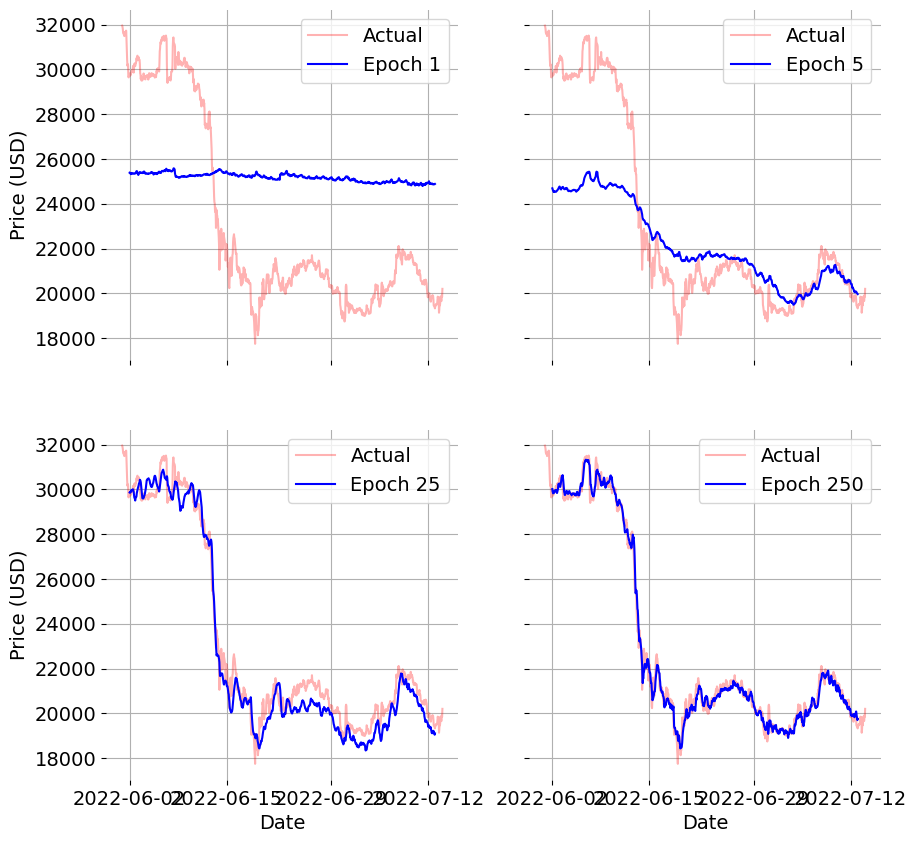

In [30]:
#Plotting Epoch Graphs
xticks = ['2022-06-02','2022-06-15','2022-06-29','2022-07-12']
yticks = [18000,20000,22000,24000,26000,28000,30000,32000]
fig, ax = plt.subplots(2,2)

ax[0,0].plot(df['price'],c='red',alpha=0.3,label='Actual')
ax[0,0].plot(x2,act_pred[0],c='blue',label = 'Epoch 1')
ax[0,0].grid()
ax[0,0].set_xticks(xticks,labels=[])
ax[0,0].tick_params(axis='y', labelsize=14)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['bottom'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].set_ylabel('Price (USD)',fontsize=14)
ax[0,0].legend(fontsize =14)


ax[0,1].plot(df['price'],c='red',alpha=0.3,label='Actual')
ax[0,1].plot(x2,act_pred[4],c='blue',label = 'Epoch 5')
ax[0,1].grid()
ax[0,1].set_xticks(xticks,labels=[])
ax[0,1].set_yticks(yticks,labels=[])
ax[0,1].tick_params(axis='y', labelsize=14)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['bottom'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
#ax[0,0].set_xlabel('Epoch')
#ax[0,1].set_ylabel('Price (USD)')
ax[0,1].legend(fontsize =14)

ax[1,0].plot(df['price'],c='red',alpha=0.3,label='Actual')
ax[1,0].plot(x2,act_pred[24],c='blue',label = 'Epoch 25')
ax[1,0].grid()
ax[1,0].set_xticks(xticks)
ax[1,0].tick_params(axis='x', labelsize=14)
ax[1,0].tick_params(axis='y', labelsize=14)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['bottom'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].set_ylabel('Price (USD)', fontsize =14)
ax[1,0].set_xlabel('Date',fontsize = 14)
ax[1,0].legend(fontsize =14)


ax[1,1].plot(df['price'],c='red',alpha=0.3,label='Actual')
ax[1,1].plot(x2,act_pred[249],c='blue',label = 'Epoch 250')
ax[1,1].grid()
ax[1,1].set_xticks(xticks)
ax[1,1].tick_params(axis='x', labelsize=14)
ax[1,1].tick_params(axis='y', labelsize=14)
ax[1,1].set_yticks(yticks,labels=[])
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['bottom'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
#ax[0,0].set_xlabel('Epoch')
#ax[0,1].set_ylabel('Price (USD)')
ax[1,1].legend(fontsize = 14)
ax[1,1].set_xlabel('Date',fontsize=14)

plt.rcParams['figure.figsize'] = [16, 10]

#plt.savefig('../Write-Up/CHAPTER_5/epoch_graph_inf.png', format='png',dpi=1000,bbox_inches='tight')
plt.show()

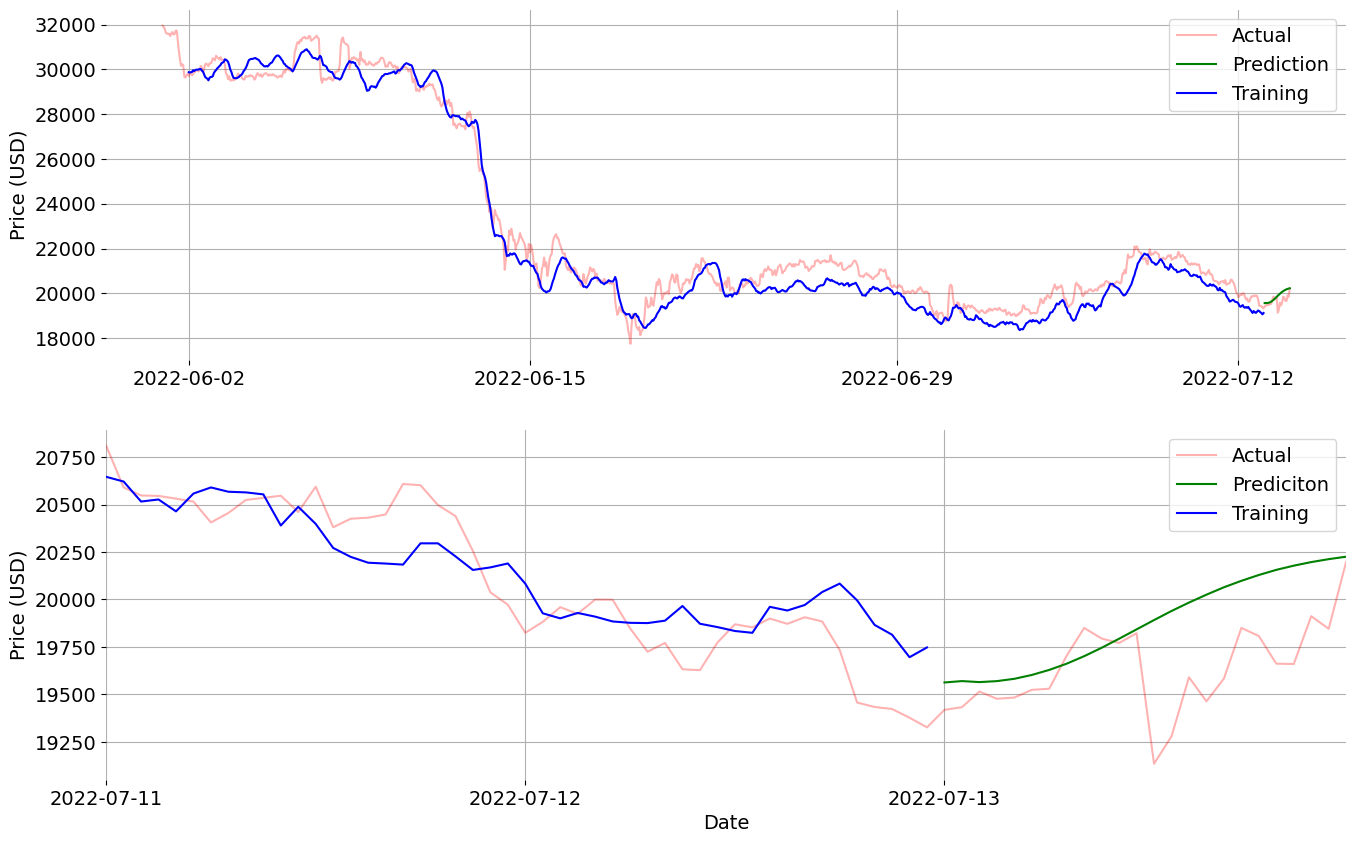

In [31]:
### Side by Side comparison of Training, testing and actual
fig, ax = plt.subplots(2,1)

xticks_1 = ['2022-06-02','2022-06-15','2022-06-29','2022-07-12']
ax[0].plot(df['price'],c='red',alpha=0.3,label='Actual')
ax[0].plot(x,predicitons_array,c='green',label = 'Prediction')
ax[0].plot(x2,act_pred[25],c='blue',label = 'Training')
ax[0].grid()

ax[0].set_xticks(xticks_1)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
#ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Price (USD)',fontsize=14)
ax[0].legend(fontsize=14)

xticks_2 = ['2022-07-11','2022-07-12','2022-07-13','2022-07-14']
ax[1].plot(df['price']['2022-07-11':],c='red',alpha=0.3,label='Actual')
ax[1].plot(x,predicitons_array,c='green',label='Prediciton')
ax[1].plot(x2[-48:],act_pred[-1][-48:],c='blue',label = 'Training')
ax[1].grid()

ax[1].set_xticks(xticks_2)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].set_xlabel('Date',fontsize=14)
ax[1].set_ylabel('Price (USD)',fontsize=14)
ax[1].legend(fontsize=14)

plt.autoscale(axis='x',tight=True)
plt.xticks(rotation = 0)
plt.rcParams['figure.figsize'] = [10, 10]
plt.savefig('../Write-Up/CHAPTER_5/result_pred_inf.png', format='png',dpi=1000,bbox_inches='tight')

plt.show()
